In [25]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

In [41]:
%run ../models/drift/wagner.py

In [15]:
%run ../models/iceberg/iceberg.py

In [18]:
%run ../models/metocean/metocean.py

In [47]:
%run ../plotting/plot.py

In [43]:
chosen_track_ind = 0

In [21]:
iip_berg_df = get_berg_df(chosen_track_ind)

In [22]:
iip_berg_df

,index,ICE-YEAR,BERG_NUMBER,DATE,TIME,LATITUDE,LONGITUDE,METHOD,SIZE,SHAPE,SOURCE,DATETIME,t2000
0,6319,2015,21511,6/16/2015,1442,48.16,-50.01,R/V,LG,TAB,GTJZ,2015-06-16 14:42:00,135494.70
1,6320,2015,21511,6/17/2015,1300,48.09,-50.02,R/V,LG,GEN,GMRS,2015-06-17 13:00:00,135517.00
2,6321,2015,21511,6/18/2015,1249,48.08,-49.76,VIS,LG,TAB,GTJZ,2015-06-18 12:49:00,135540.82


In [27]:
 iip_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                       iip_berg_df['DATETIME'].loc[:].tolist(),
                       iip_berg_df['t2000'].loc[:].tolist(),
                       iip_berg_df['LATITUDE'].loc[:].tolist(),
                       iip_berg_df['LONGITUDE'].loc[:].tolist(),
                       iip_berg_df['SIZE'].loc[0])
    
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.times[0], iip_berg.times[-1])

ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.times[0], iip_berg.times[-1])

wind_u_interp = atm_data.wind_u_interp
wind_v_interp = atm_data.wind_v_interp  
water_u_interp = ocean_data.water_u_interp 
water_v_interp = ocean_data.water_v_interp
water_temp_interp = ocean_data.water_temp_interp

Run number: 0, h = 5.0, l = 2.5, w = 2.5
rollover
swap l and w
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
melted
Final time: 135526.4
Run number: 0, h = 30.0, l = 10.0, w = 10.0
rollover
swap l and w
rollover
rollover
Final time: 135540.9
Run number: 0, h = 100.0, l = 37.5, w = 37.5
rollover
swap l and w
Final time: 135540.9
Run number: 0, h = 300.0, l = 90.0, w = 90.0
rollover
swap l and w
Final time: 135540.9
Run number: 0, h = 600.0, l = 60.0, w = 60.0
rollover
swap l and w
Final time: 135540.9
Run number: 0, h = 562.5, l = 150.0, w = 150.0
rollover
swap l and w
Final time: 135540.9


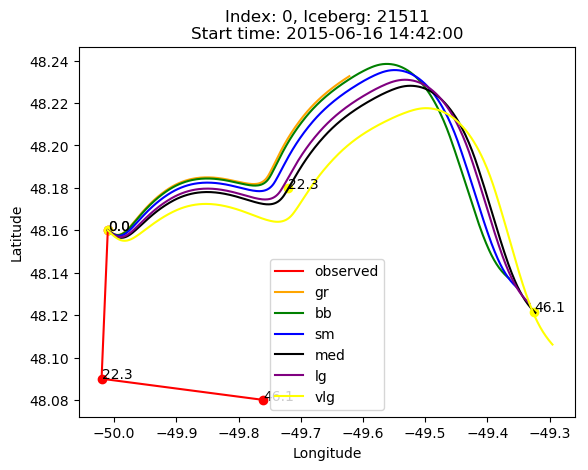

In [45]:
# Timesteps

t0 = iip_berg.t2000[0]
tf = iip_berg.t2000[-1]
tstep = 0.1
t_all = np.arange(t0, tf + tstep, tstep)
dt = tstep*3600  # timestep in seconds



berg_sizes = ['GR', 'BB', 'SM', 'MED', 'LG', 'VLG']
bergs_by_size = []

plot_list = []

for berg_size in berg_sizes:
    
    mod_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                       [iip_berg_df['DATETIME'].loc[0]],
                       [iip_berg_df['t2000'].loc[0]],
                       [iip_berg_df['LATITUDE'].loc[0]],
                       [iip_berg_df['LONGITUDE'].loc[0]],
                       berg_size)
    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]
    # Iceberg Initial Location
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]

    # Run number
    run_num = 0
    num_runs = 1

    # Buffer number for bounding spatial box
    buf = 0.5

    # Manual stop time
    #stop_time = 36
    stop_time = tf

    # Initialize output dict
    output_dict = {}

    for run_num in range(num_runs):

        # Iceberg Initials
        l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
        l0 = l0 + l0*0.1*run_num
        w0 = w0 + w0*0.1*run_num
        h0 = h0 + h0*0.1*run_num
        l, w, h = l0, w0, h0
        x, y = x0, y0
        t = t0
        #iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

        print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

        while t < stop_time:

            #print('Timestep: {}'.format(t))

            x_new, y_new, l_new, w_new, h_new = wagner_drift(t, x, y, l, w, h, wind_u_interp, wind_v_interp, water_u_interp, water_v_interp, water_temp_interp, dt)
            

            if x_new > max(iip_berg.lons)+buf or x_new < min(iip_berg.lons)-buf or y_new > max(iip_berg.lats)+buf or y_new <= min(iip_berg.lats)-buf:
                # Iceberg out-of-bounds
                print('out-of-bounds')
                break


            if l_new <= 0 or w_new <= 0 or h_new <= 0:
                # Iceberg melted
                print('melted')
                break

            else:
                x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
                t += tstep
                t = round(t, 1)
                #iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
                mod_berg.times_ref0.append(t)
                mod_berg.t2000.append(t)
                mod_berg.lons.append(x)
                mod_berg.lats.append(y)
                mod_berg.length.append(l)
                mod_berg.width.append(h)
                #iceberg = np.column_stack((iceberg, iceberg_new))

    print("Final time: {}".format(t)) 
    bergs_by_size.append(mod_berg)

#plot1(iip_berg, mod_berg)
#plot = plot_return(iip_berg, mod_berg)
plot = plot_return_size_vary(iip_berg, bergs_by_size[0], bergs_by_size[1],
                            bergs_by_size[2],bergs_by_size[3],bergs_by_size[4],
                            bergs_by_size[5], chosen_track_ind)

plot_list.append(plot)
if not os.path.exists('plots'):
    os.makedirs('plots')
with PdfPages('plots/plots_size_vary.pdf') as pdf:
    for plot in plot_list:
        pdf.savefig(plot)